Training Step: 7659  | total loss: 0.14580 | time: 7.753s
| Adam | epoch: 020 | loss: 0.14580 - acc: 0.9456 -- iter: 24448/24500
Training Step: 7660  | total loss: 0.14143 | time: 8.775s
| Adam | epoch: 020 | loss: 0.14143 - acc: 0.9479 | val_loss: 0.94241 - val_acc: 0.7540 -- iter: 24500/24500
--


100%|██████████| 12500/12500 [00:12<00:00, 997.91it/s] 


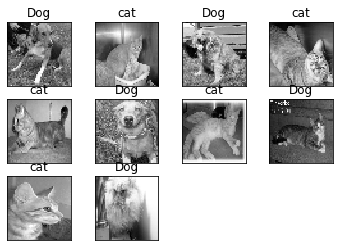

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import numpy as np
import os
from random import shuffle
import cv2
from google.colab import drive
drive.mount("/content/drive")

train_file="/content/drive/My Drive/Colab Notebooks/train.zip"
test_file="/content/drive/My Drive/Colab Notebooks/test.zip"

import zipfile
with zipfile.ZipFile(train_file,'r') as z:
  z.extractall()
with zipfile.ZipFile(test_file,'r') as z:
  z.extractall()
  
TEST_DIR="./test/"
TRAIN_DIR="./train/"
LEARNING_RATE=1e-3
MODEL_NAME="dogsvscats-{}-{}.model".format(LEARNING_RATE,"6conv-fire")
IMG_SIZE=50


def label_image(img):
    img_name=img.split(".")[-3]
    if img_name=="cat":
       return[1,0]
    elif img_name=="dog":
       return[0,1]
	   
def create_train_data():
    training_data=[]
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label=label_image(img)
        path=os.path.join(TRAIN_DIR,img)
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy',training_data)
    return training_data
 
train_data=create_train_data()

import tflearn
from tflearn.layers.conv import conv_2d,max_pool_2d
from tflearn.layers.core import input_data,dropout,fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()
convnet=input_data(shape=[None,IMG_SIZE,IMG_SIZE,1],name='input')
convnet=conv_2d(convnet,32,5,activation='relu')
convnet=max_pool_2d(convnet,5)
convnet=conv_2d(convnet,64,5,activation='relu')
convnet=max_pool_2d(convnet,5)
convnet=conv_2d(convnet,128,5,activation='relu')
convnet=max_pool_2d(convnet,5)
convnet=conv_2d(convnet,64,5,activation='relu')
convnet=max_pool_2d(convnet,5)
convnet=conv_2d(convnet,32,5,activation='relu')
convnet=max_pool_2d(convnet,5)
convnet=fully_connected(convnet,1024,activation='relu')
convnet=dropout(convnet,0.8)
convnet=fully_connected(convnet,2,activation='softmax')
convnet=regression(convnet,optimizer='adam',learning_rate=LEARNING_RATE,loss='categorical_crossentropy',name='targets')
model=tflearn.DNN(convnet,tensorboard_dir='log')


if os.path.exists('{}.meta'.format(MODEL_NAME)):
   model.load(MODEL_NAME)
   print('model loaded!')
  
train=train_data[:-500]
test=train_data[-500:]

X=np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y=[i[1] for i in train]
test_x=np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y=[i[1] for i in test]

model.fit({'input':X},{'targets':Y},n_epoch=10,validation_set=({'input':test_x},{'targets':test_y}),snapshot_step=500,show_metric=True,run_id=MODEL_NAME)

model.fit({'input':X},{'targets':Y},n_epoch=10,validation_set=({'input':test_x},{'targets':test_y}),snapshot_step=500,show_metric=True,run_id=MODEL_NAME)

testing_data=[]
for img in tqdm(os.listdir("./test/")):
    path=os.path.join("./test",img)
    img_num=img.split('.')[0]
    img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    testing_data.append([np.array(img),img_num])

fig=plt.figure()
for num,data in enumerate(testing_data[:10]):
    img_num=data[1]
    img_data=data[0]
    y= fig.add_subplot(3,4,num+1)
    orig=img_data
    data=img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out=model.predict([data])[0]
    if np.argmax(model_out)==1:str_label='Dog'
    else: str_label='cat'
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

	

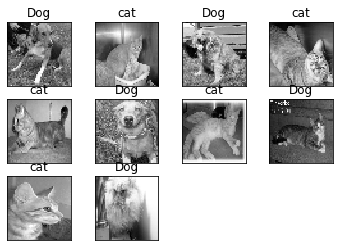